In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
# load the dataset
from os import listdir
from os.path import isfile, join


# Dataset from kaggle: 
# https://www.kaggle.com/fanconic/skin-cancer-malignant-vs-benign
# Load Dataset:
# from the folder of images create dataframe with file-labels
train_benign = [['../data/train/benign/{}'.format(f), 1 ] for f in listdir('../data/train/benign/') if isfile(join('../data/train/benign/', f))]
train_malignant = [['../data/train/malignant/{}'.format(f), 0 ] for f in listdir('../data/train/malignant/') if isfile(join('../data/train/malignant/', f))]


test_benign = [['../data/test/benign/{}'.format(f), 1 ] for f in listdir('../data/test/benign/') if isfile(join('../data/test/benign/', f))]
test_malignant = [['../data/test/malignant/{}'.format(f), 0 ] for f in listdir('../data/test/malignant/') if isfile(join('../data/test/malignant/', f))]


files = pd.DataFrame(train_benign+train_malignant+test_benign+test_malignant,
                     columns=['img', 'binary_label'])#.sample(frac=1, random_state=1869097)
files.head()

img  binary_label
0   ../data/train/benign/189.jpg             1
1    ../data/train/benign/77.jpg             1
2   ../data/train/benign/837.jpg             1
3  ../data/train/benign/1353.jpg             1
4  ../data/train/benign/1435.jpg             1

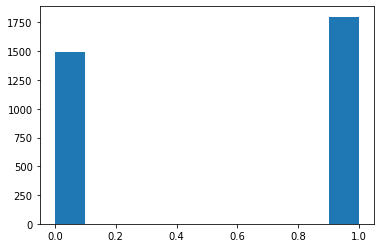

In [3]:
# see the proportion of malignant (label 0) and benign (label 1) images
paths = files.iloc[:, 0].values
labels = files.iloc[:, 1].astype(np.int32).values

_ = plt.hist(labels)

In [4]:
# count them
neg, pos = np.bincount(labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} ({:.2f}% of total)' 
      .format(total, pos, 100 * pos / total, neg, 100*neg/total))

Examples:
    Total: 3297
    Positive: 1800 (54.60% of total)
    Negative: 1497 (45.40% of total)


In [5]:
from sklearn.model_selection import train_test_split

# splitting in train, validation and test
# random state for reproducebility
X_target, X_test, y_target, y_test = train_test_split(paths, labels, test_size=0.15, shuffle=True, stratify=labels,
                                                      random_state=1869097)

X_train, X_val, y_train, y_val = train_test_split(X_target, y_target, test_size=0.15, shuffle=True, stratify=y_target,
                                                  random_state=1869097)

print('train len', len(X_train), np.round(np.bincount(y_train)/len(y_train),2))
print('validation len', len(X_val), np.round(np.bincount(y_val)/len(y_val),2))
print('test len', len(X_test), np.round(np.bincount(y_test)/len(y_test),2))

train len 2381 [0.45 0.55]
validation len 421 [0.45 0.55]
test len 495 [0.45 0.55]


In [6]:
import tensorflow as tf
#tf.random.set_seed(1869097)

In [7]:
# create tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [8]:
# see one example of image
for xb, yb in train_dataset.batch(4).take(1):
    print(xb)
    print(yb)

tf.Tensor(
[b'../data/train/malignant/135.jpg' b'../data/train/malignant/225.jpg'
 b'../data/test/benign/1748.jpg' b'../data/train/benign/682.jpg'], shape=(4,), dtype=string)
tf.Tensor([0 0 1 1], shape=(4,), dtype=int32)


In [9]:
# PREPROCESSING AND AUGMENTATION FUNCTIONS 

# Preprocess the dataset in order to load each image:
# After applying this function, each pair (path, label) is converted to (image, label)
def preprocess(path, label):
    full_path = path # Actual path
    image = tf.io.read_file(full_path)
    image = tf.io.decode_image(image, channels=3) # decoding image (with 3 channels RGB)
    image = tf.image.resize_with_crop_or_pad(image, 224, 244) # Crop or pad to a specific dimension
    image = tf.cast(image, tf.float32) / 255.0 # Normalize the image to [0.0, 1.0]

    label = tf.cast(label, tf.int32)
    return image, label


# data augmentation for an image
def augment(image, label):

    # randomly Rotate 
    image = tf.image.rot90(image, k=4)

    # random flip left-rigt and up-down
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    #image = tf.image.random_crop(image, 
    #                             size= [image.shape[0], image.shape[1], 3])

    # color augmentation
    #image = tf.image.random_hue(image, 0.05)
    image = tf.image.random_saturation(image, 0.8, 1.3)
    image = tf.image.random_brightness(image, 0.09)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    return image, label

In [10]:
# ALREADY TRAINED MODELS
# function to show the history of the training 
def show_results(history, par1='accuracy', par2='val_accuracy'):
    import matplotlib.pyplot as plt
    plt.plot(list(history[par1].values()))
    plt.plot(list(history[par2].values()))
    plt.title('model {}'.format(par1))
    plt.ylabel(par1)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

    return

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

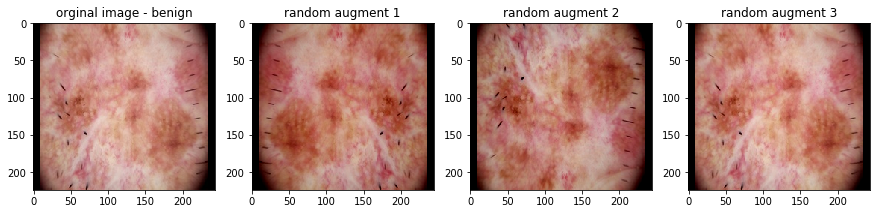

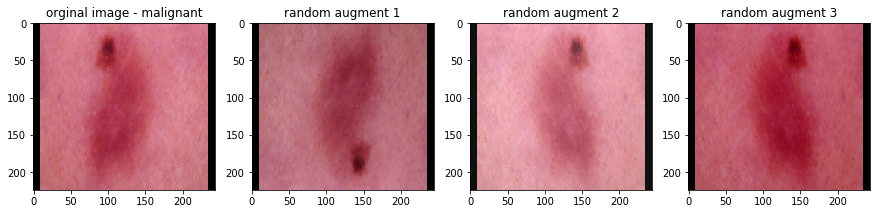

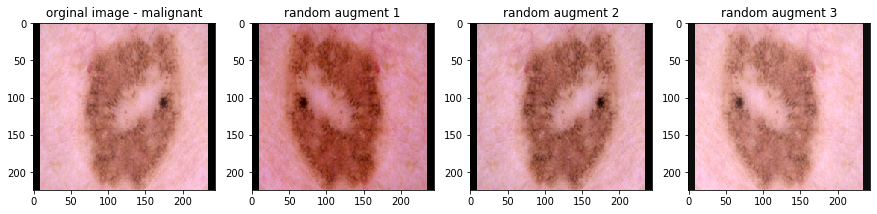

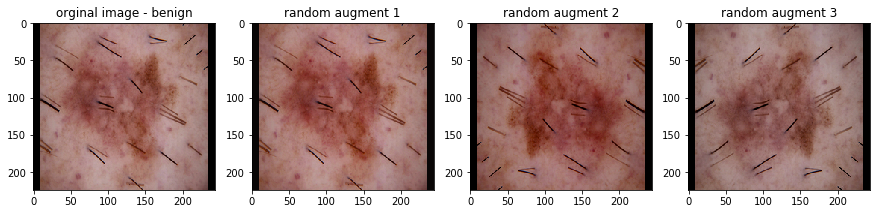

In [11]:
import matplotlib.pyplot as plt
from warnings import filterwarnings


# DATA AUGMENTATION: SOME EXAMPLES
cnt = 0

decoder = {0:'benign', 1: 'malignant'}
for xb, yb in train_dataset.map(preprocess).batch(10).shuffle(1).take(4):
    #print(yb.numpy()[0:4])
    
    fig = plt.figure(figsize=(15,18))

    ax1 = fig.add_subplot(1,4,1)
    ax1.imshow(xb[0])
    ax1.set_title('orginal image - ' + decoder[yb[0].numpy()])
    ax2 = fig.add_subplot(1,4,2)
    ax2.imshow(augment(xb[0],yb)[0])
    ax2.set_title('random augment 1')
    ax3 = fig.add_subplot(1,4,3)
    ax3.imshow(augment(xb[0],yb)[0])
    ax3.set_title('random augment 2')
    ax4 = fig.add_subplot(1,4,4)
    ax4.imshow(augment(xb[0],yb)[0])
    ax4.set_title('random augment 3')

    cnt += 1
    if cnt==5:
        break
        

## BASELINE MODEL

In [12]:
def build_model(n_blocks=4):
    from tensorflow.keras import Model
    from tensorflow.keras import layers, regularizers, initializers

    images = layers.Input(shape=(224, 244, 3))

    def add_block(x, n_filters, strides=2):
        # Convolutional block with custom initialization and regularization
        x = layers.Conv2D(n_filters, 5, padding='same', strides=strides, 
                          kernel_regularizer=regularizers.l2(0.001),
                          kernel_initializer=initializers.glorot_normal())(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        return x

    x = add_block(images, 32)

    for i in range(1, n_blocks + 1):
        x = add_block(x, 64 * i)

    x = layers.Flatten()(x)
    x = layers.Dense(1028, activation='relu')(x)
    x = layers.Dense(516, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1, activation='sigmoid')(x) 

    net = Model(inputs=[images], outputs=[x])

    net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return net

In [13]:
net = build_model()
net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 244, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 122, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 122, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 112, 122, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 61, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 61, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 56, 61, 64)        0     

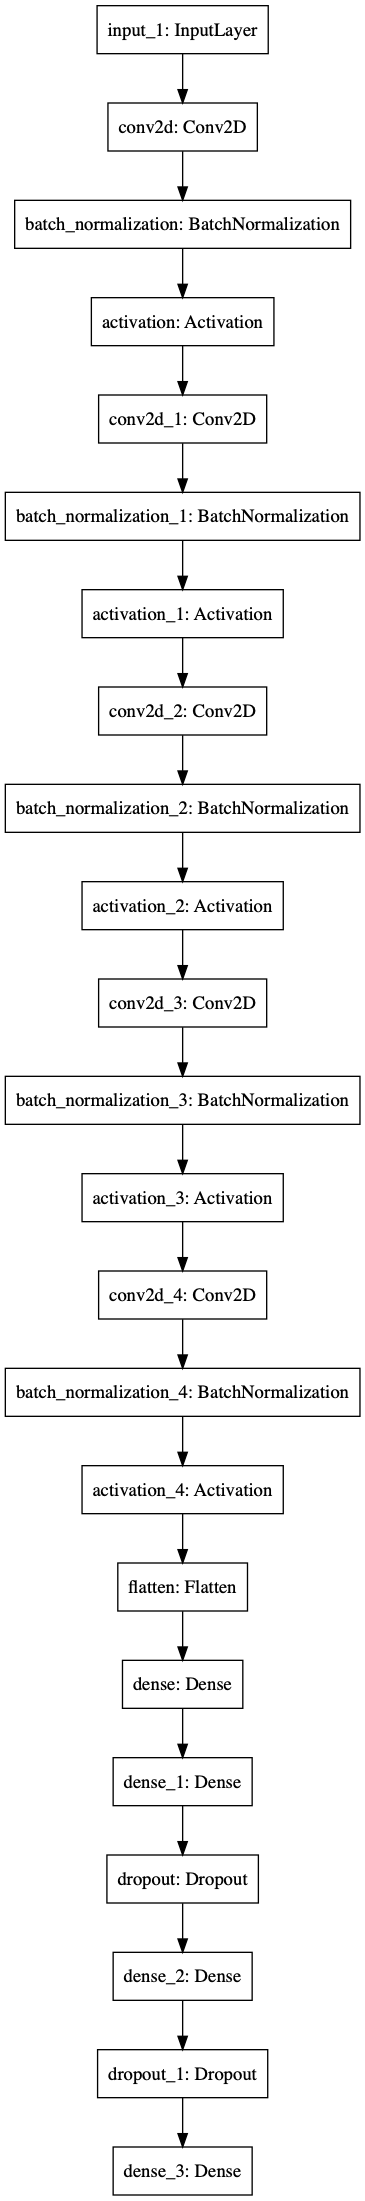

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(net)

In [15]:
#### training: Done using colab

# from tensorflow.keras.callbacks import ReduceLROnPlateau
# learning_control = ReduceLROnPlateau(monitor='val_accuracy', 
#                                      patience=3, verbose=1, factor=.5, min_lr=0.00001)


#### Save the model with best weights (best result w.r.t. loss metrics)
# from tensorflow.keras.callbacks import ModelCheckpoint


# chkpoint_path= '/content/gdrive/My Drive/Colab Notebooks/BDOS/checkpoints/base_model/epochs:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5'
# checkpointer = ModelCheckpoint(chkpoint_path, verbose=1,save_best_only=True)

# history = net.fit(train_dataset.map(preprocess).map(augment).shuffle(100).batch(64), 
#                   epochs=80, 
#                   validation_data=val_dataset.map(preprocess).map(augment).batch(64), 
#                   callbacks=[learning_control, checkpointer])


#### Save history.history dictionary as a pandas DataFrame
# csv_path = '/content/gdrive/My Drive/Colab Notebooks/BDOS/history/'
# pd.DataFrame.from_dict(history.history).to_csv(csv_path+'base_model.csv', index=False)



In [16]:
# load history an show the results
df = pd.read_csv('history/base_model.csv')
df.head()

loss  accuracy   val_loss  val_accuracy     lr
0  1.867318  0.645947  13.532770      0.546318  0.001
1  1.102221  0.737925   1.334255      0.558195  0.001
2  0.963012  0.758925   1.013740      0.636580  0.001
3  0.915425  0.774885   1.318588      0.553444  0.001
4  0.811264  0.802184   0.960998      0.643705  0.001

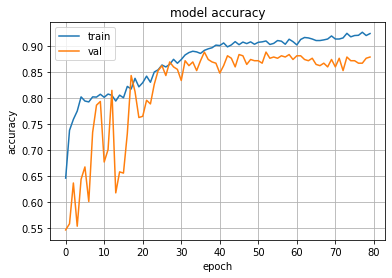

In [17]:
# show accuracy history
show_results(df.to_dict(), 'accuracy', 'val_accuracy')

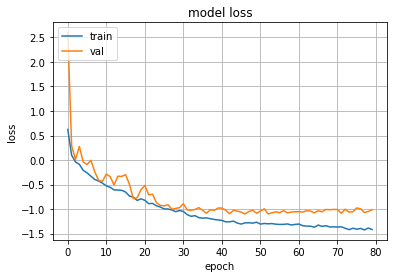

In [18]:
# show loss history (log-scale)
df.loss = df.loss.apply(lambda x : np.log(x))
df.val_loss = df.val_loss.apply(lambda x : np.log(x))

show_results(df.to_dict(), 'loss', 'val_loss')

In [19]:
# now load the model weights and make predictions on train, validation and test
net.load_weights('checkpoint/basemodel/epochs_053-val_acc_0.888.hdf5')

In [20]:
def predict_images(dataset, batchsize=32):
    from sklearn.metrics import confusion_matrix

    @tf.function
    def predict(x):
        return net(x, training=False)

    y_pred = []
    y_true = []

    for xb, yb in dataset.map(preprocess).batch(batchsize):
        for i in range(yb.shape[0]):
            pred = predict(tf.reshape(xb[i], (1,224,244,3))).numpy()[0][0]
            y_true.append(yb[i].numpy())
            y_pred.append(round(pred).astype(np.int32))

    accuracy = np.sum(np.round(y_pred)==y_true)/len(y_pred)

    return y_true, y_pred, accuracy, confusion_matrix(y_true, y_pred)

In [21]:

# predict on train
print('train prediction:')
y_true, y_pred, acc, confusion_matrix = predict_images(train_dataset)
print(net.evaluate(train_dataset.map(preprocess).batch(64)))
print(confusion_matrix,'\n----------------')


print('validation prediction:')
y_true, y_pred, acc, confusion_matrix = predict_images(val_dataset)
print(net.evaluate(val_dataset.map(preprocess).batch(64)))
print(confusion_matrix,'\n----------------')

# predict on test
print('test prediction:')
y_true, y_pred, acc, confusion_matrix = predict_images(test_dataset)
print(net.evaluate(test_dataset.map(preprocess).batch(64)))
print(confusion_matrix,'\n----------------')


train prediction:
38/38 [==============================] - 48s 1s/step - loss: 0.2773 - accuracy: 0.9118
[0.27725323838622945, 0.91180176]
[[ 941  140]
 [  70 1230]] 
----------------
validation prediction:
7/7 [==============================] - 8s 1s/step - loss: 0.3061 - accuracy: 0.9074
[0.30605115422180723, 0.9073634]
[[173  18]
 [ 21 209]] 
----------------
test prediction:
8/8 [==============================] - 10s 1s/step - loss: 0.3192 - accuracy: 0.8949
[0.31924586556851864, 0.8949495]
[[191  34]
 [ 18 252]] 
----------------


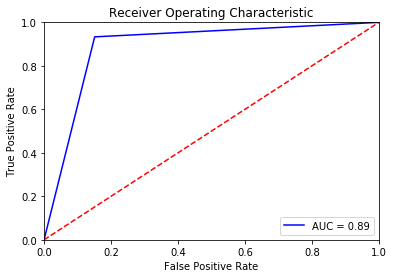

In [22]:
from sklearn.metrics import roc_curve, auc

# ROC curve
fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr) 

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


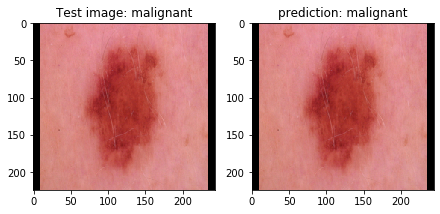

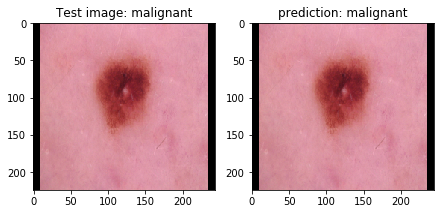

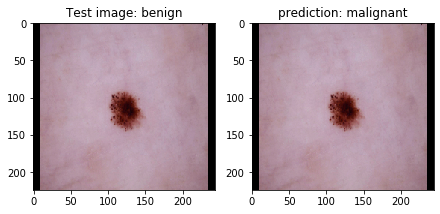

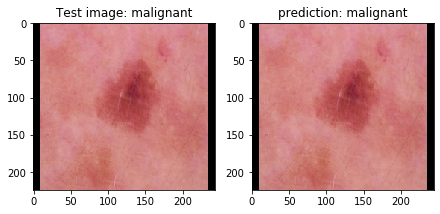

In [23]:
# some random predictions
@tf.function
def predict(x):
    return net(x, training=False)

decoder = {0:'benign', 1:'malignant'}



for xb, yb in test_dataset.map(preprocess).shuffle(100).batch(4):
    for i in range(yb.shape[0]):
            true = yb[i].numpy()
            pred = predict(tf.reshape(xb[i], (1,224,244,3))).numpy()[0][0]
            
            
            fig = plt.figure(figsize=(15,18))
            
            ax1 = fig.add_subplot(1,4,1)
            ax1.imshow(xb[i])
            ax1.set_title('Test image: ' + decoder[true])
            ax2 = fig.add_subplot(1,4,2)
            ax2.imshow(xb[i])
            ax2.set_title('prediction: ' + decoder[round(pred)])
            
            
    break

----------
## InceptionV3

In [24]:
def build_model():
    from tensorflow.keras.models import Sequential
    from tensorflow.keras import layers

    from tensorflow.keras.applications.inception_v3 import InceptionV3

    base_model = InceptionV3(include_top=False, input_tensor=None, input_shape=(224,224,3),
                          pooling='avg', classes=2)

    net= Sequential()
    net.add(layers.Input(shape=(224, 244, 3)))
    net.add(base_model)

    net.add(layers.Flatten())
    net.add(layers.Dense(100,activation='relu'))
    net.add(layers.Dropout(0.4))
    net.add(layers.Dense(1, activation='sigmoid'))

    net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return net


In [25]:
net = build_model()
net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               204900    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 22,007,785
Trainable params: 21,973,353
Non-trainable params: 34,432
_________________________________________________________________


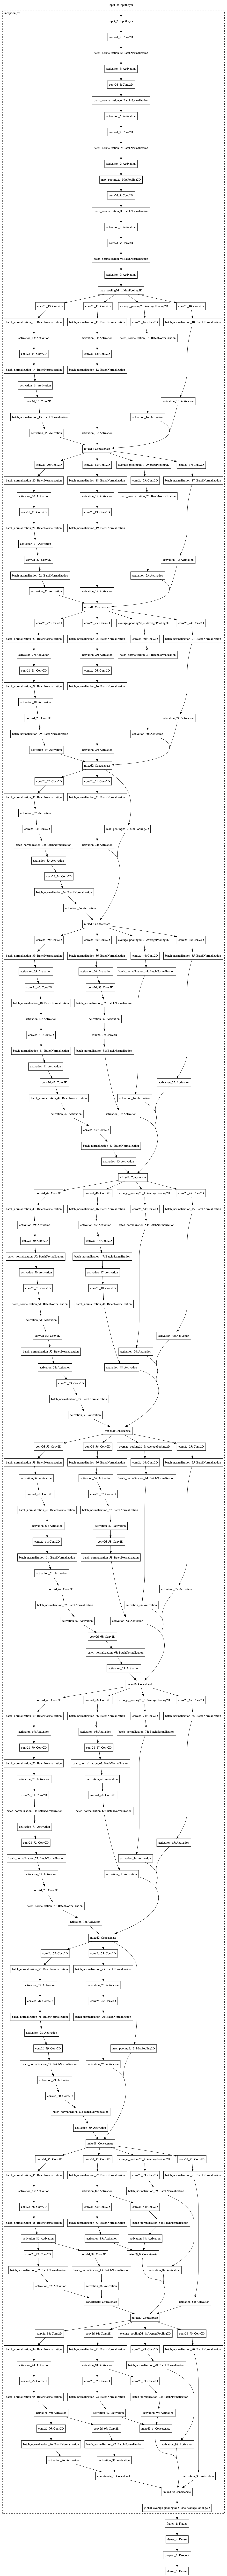

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(net, expand_nested=True)

In [27]:
#### training: Done using colab

# from tensorflow.keras.callbacks import ReduceLROnPlateau
# learning_control = ReduceLROnPlateau(monitor='val_accuracy', 
#                                      patience=3, verbose=1, factor=.5, min_lr=0.00001)


#### Save the model with best weights (best result w.r.t. loss metrics)
# from tensorflow.keras.callbacks import ModelCheckpoint


# chkpoint_path= '/content/gdrive/My Drive/Colab Notebooks/BDOS/checkpoints/inception/epochs:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5'
# checkpointer = ModelCheckpoint(chkpoint_path, verbose=1,save_best_only=True)

# history = net.fit(train_dataset.map(preprocess).map(augment).shuffle(100).batch(64), 
#                   epochs=80, 
#                   validation_data=val_dataset.map(preprocess).map(augment).batch(64), 
#                   callbacks=[learning_control, checkpointer])



#### Save history.history dictionary as a pandas DataFrame
# csv_path = '/content/gdrive/My Drive/Colab Notebooks/BDOS/history/'
# pd.DataFrame.from_dict(history.history).to_csv(csv_path+'inception.csv', index=False)




In [28]:
df = pd.read_csv('history/inception.csv')
df.head()

loss  accuracy   val_loss  val_accuracy     lr
0  0.459515  0.776640  11.438972      0.457576  0.001
1  0.371632  0.821009   1.495510      0.839394  0.001
2  0.350014  0.837694   0.787644      0.827273  0.001
3  0.360010  0.840349   0.722638      0.827273  0.001
4  0.326074  0.857035   0.387283      0.836364  0.001

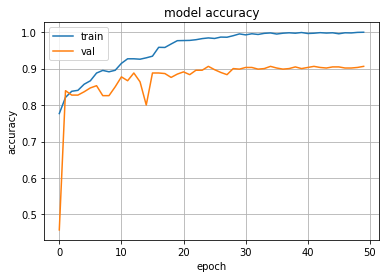

In [29]:
show_results(df.to_dict(), 'accuracy', 'val_accuracy')

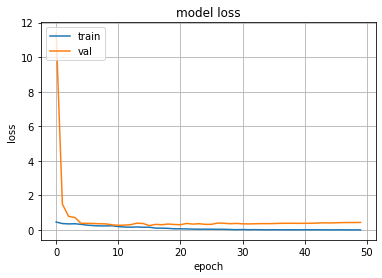

In [30]:
show_results(df.to_dict(), 'loss', 'val_loss')

In [31]:
# now load the model weights and make predictions on train, validation and test
net.load_weights('checkpoint/inception/epochs_016-val_acc_0.888.hdf5')

In [32]:
# predict on train
print('train prediction:')
y_true, y_pred, acc, confusion_matrix = predict_images(train_dataset)
print(net.evaluate(train_dataset.map(preprocess).batch(32)))
print(confusion_matrix,'\n----------------')

# predict on validation
print('validation prediction:')
y_true, y_pred, acc, confusion_matrix = predict_images(val_dataset)
print(net.evaluate(val_dataset.map(preprocess).batch(32)))
print(confusion_matrix,'\n----------------')

# predict on test
print('test prediction:')
y_true, y_pred, acc, confusion_matrix = predict_images(test_dataset)
print(net.evaluate(test_dataset.map(preprocess).batch(32)))
print(confusion_matrix,'\n----------------')



train prediction:
75/75 [==============================] - 207s 3s/step - loss: 0.1408 - accuracy: 0.9483
[0.1407935989399751, 0.948341]
[[1018   63]
 [  60 1240]] 
----------------
validation prediction:
14/14 [==============================] - 107s 8s/step - loss: 0.1634 - accuracy: 0.9216
[0.16339193231293134, 0.9216152]
[[175  16]
 [ 17 213]] 
----------------
test prediction:
16/16 [==============================] - 39s 2s/step - loss: 0.1589 - accuracy: 0.9414
[0.15890406584367156, 0.9414141]
[[212  13]
 [ 16 254]] 
----------------


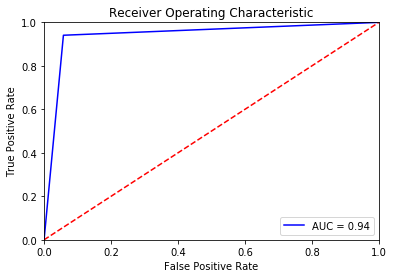

In [33]:
from sklearn.metrics import roc_curve, auc

# roc curve 
fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr) 

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



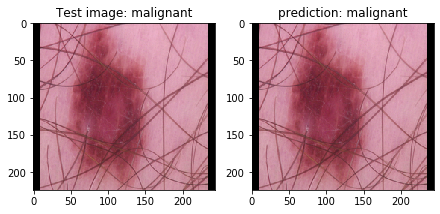

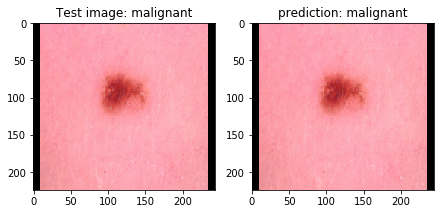

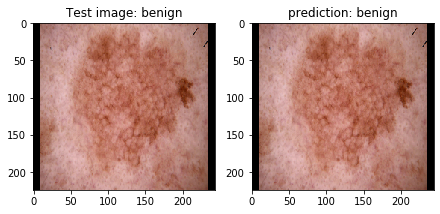

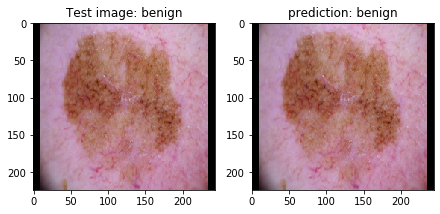

In [34]:
@tf.function
def predict(x):
    return net(x, training=False)

decoder = {0:'benign', 1:'malignant'}


for xb, yb in test_dataset.map(preprocess).shuffle(100).batch(4):
    for i in range(yb.shape[0]):
            true = yb[i].numpy()
            pred = predict(tf.reshape(xb[i], (1,224,244,3))).numpy()[0][0]
            
            
            fig = plt.figure(figsize=(15,18))
            
            ax1 = fig.add_subplot(1,4,1)
            ax1.imshow(xb[i])
            ax1.set_title('Test image: ' + decoder[true])
            ax2 = fig.add_subplot(1,4,2)
            ax2.imshow(xb[i])
            ax2.set_title('prediction: ' + decoder[round(pred)])
            
            
    break